In [1]:
#%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pickle

In [ ]:
# funcion secundaria encontrar la posición de la incidencia de un muon (centro de carga por matriz)
def conteo(res, evento, n_counts, range_can): # imagen (x,y), el evento a revisar, cantidad de conteos totales, rango de canales activados
    
    n = len(evento) # cantidad de canales activados en el evento
    lix = [i for i in evento if i <= 28] # canales 0-28
    liy = [i for i in evento if i >= 32 and i <= 60] # canales 32-60
    
    # Discrimina rondas con cuadruples y que esten juntos cada pareja
    if len(lix) in range_can[0] and len(liy) in range_can[1] and len(lix)+len(liy)!=2:
        
        # Se hace un subdiccionario para los dos ejes y dos listas para la diferencia de indice entre
        # los canales adyacentes para discriminar si son contiguos: la suma debe dar la cantidad de canales -1
        x = {}
        y = {}
        difx = []
        dify = []
        ant = 0
        for llave, valor in evento.items():
            if llave <= 28:
                x[llave] = valor
                if len(x) >= 2:
                    difx.append(llave - ant)
            elif llave >= 32 and llave <= 60:
                y[llave] = valor
                if len(y) >= 2:
                    dify.append(llave - ant)
                
            ant = llave
        
        # Discrimina si son contiguos: la suma debe dar la cantidad de canales -1
        if sum(difx) == len(x)-1 and sum(dify) == len(y)-1:
            
            # Se suman los el producto de la posición del canal (#canal*2cm) y la carga asociada
            # y se divide por la cantidad de canales del evento
            
            carga_x = np.array(list(x.values()))
            carga_y = np.array(list(y.values()))
            pos_x = sum(carga_x * (np.array(list(x.keys())) + 1) * 2) / sum(carga_x) # sumar 1 para que el canal 0 sea 2cm
            pos_y = sum(carga_y * (np.array(list(y.keys())) - 31) * 2) / sum(carga_y) # restar 31 para que el canal 32 sea 2cm
            
            carga = sum(carga_x) + sum(carga_y)
            val = [pos_x, pos_y,carga]
            res = np.vstack([res,val])

            n_counts.append(n)
            
            
            
            return res, n_counts

        else:
            return None
    else:
        return None


def resolucion(df_boss, df_sub, range_can, td_hg): # df_boss: dataframe de la toma del líder, df_sub: dataframe de la toma del subdito, 
                                                    #range_can: rango de canales activados, td_hg: umbral de discriminación para el H gain
    # respuesta imagen (x,y,carga)
    res_b = np.empty((0, 3))
    res_s = np.empty((0, 3))
    
    # Lista de cantidad de canales activados por disparo con HG y LG
    n_counts_b= [] 
    n_counts_s= [] 
    
    # Conteos totales por disparo {Núm.canales:contador}
    conteo_total_b = {}
    conteo_total_s = {}

    # Se llenan los disccionarios
    for i in range(65):
        conteo_total_b[i] = 0
        conteo_total_s[i] = 0
    
    # Recorre cada ronda de activación - i-ésima ronda
    for i in range(int(min(len(df_boss)/64, len(df_sub)/64))):
        
        # Lista de los canales activos para aquellos discriminados en funcion de el HG, LG o b-ambos
        bg_event = {}
        sg_event = {}
        
        # Recorre todos los canales de la ronda de activación - j-ésimo canal de la i-ésimo disparo
        for j in range(64):
            
            # Valor del H/L gain
            bg = df_boss["HG"].values[i*64 + j]
            sg = df_sub["HG"].values[i*64 + j]

            # Discrimina y agrega el canal a la lista de canales activados
            if bg > td_hg:
                bg_event[j] = bg
            if sg > td_hg:
                sg_event[j] = sg
        
        # Agrega cantidad de canales activados en el disparo
        conteo_total_b[len(bg_event)] += 1
        conteo_total_s[len(sg_event)] += 1
        
        conteo_total = [conteo_total_b,conteo_total_s]
        
        con_b = conteo(res_b, bg_event, n_counts_b, range_can)
        con_s = conteo(res_s, sg_event, n_counts_s, range_can)
        
        # Si la función conteo devuelve un valor, se agrega a la respuesta
        if con_b is not None and con_s is not None:
            res_b, n_counts_b = con_b
            res_s, n_counts_s = con_s
            
        

    datos_b = res_b, n_counts_b
    datos_s = res_s, n_counts_s     
    
    return datos_b, datos_s, conteo_total

Se leen los dos archivos boss y subdito

In [ ]:
# Para las posteriores pruebas tome los primeros valores (considere su capacidad de memoria)

"""df_boss = pd.read_parquet('Datos\Toma_Hodoscopio_1m\Toma_15h\Toma_lider\Toma_datos_1h.parquet', engine='pyarrow')
df_sub = pd.read_parquet('Datos\Toma_Hodoscopio_1m\Toma_15h\Toma_sub\Toma_datos_1h.parquet', engine='pyarrow')
"""

"df_boss = pd.read_parquet('Datos\\Toma_Hodoscopio_1m\\Toma_15h\\Toma_lider\\Toma_datos_1h.parquet', engine='pyarrow')\ndf_sub = pd.read_parquet('Datos\\Toma_Hodoscopio_1m\\Toma_15h\\Toma_sub\\Toma_datos_1h.parquet', engine='pyarrow')\n"

In [ ]:
td_hg = 1000 
range_can = [[1,2],[1,2]]
df_boss = pd.read_parquet('Datos/Toma_Hodoscopio_1m/Toma_15h/Toma_lider/Toma_peque.parquet', engine='pyarrow')
df_sub = pd.read_parquet('Datos/Toma_Hodoscopio_1m/Toma_15h/Toma_sub/Toma_peque', engine='pyarrow')

total = resolucion(df_boss, df_sub, range_can, td_hg)

datos_b, datos_s, conteo_total = total
res_b, n_counts_b = datos_b
res_s, n_counts_s = datos_s
conteo_total_b, conteo_total_s = conteo_total

Comprovación de estado de fase

In [ ]:
# Promedio de la distancia proyectada entre matrices - Cada promedio asocia una toma adaptada con diferente desfase de los disparos
# Se elimina los primeros i disparos de una matriz y se asocia el i-ésimo+1 disparo con el primero de la otra
# Se busca ver si la distancia promedio cambia ya que si está en fase la distancia seram mínima, si está en desfase, toma valores aleatorios y aumentara la distancia
mean = []
for i in range(0,100):
    df_boss2 = df_boss.iloc[i*64:]

    total = resolucion(df_boss2, df_sub, range_can, td_hg)

    datos_b, datos_s, conteo_total = total
    res_b, n_counts_b = datos_b
    res_s, n_counts_s = datos_s
    conteo_total_b, conteo_total_s = conteo_total

    xb = res_b[:,0]
    yb = res_b[:,1]

    xs = res_s[:,0]
    ys = res_s[:,1]

    resx = xb-xs
    resy = yb-ys

    m = np.mean(np.sqrt(resx**2 + resy**2))
    mean.append(m)

Text(0, 0.5, 'Distancia promedio proyectada entre puntos')

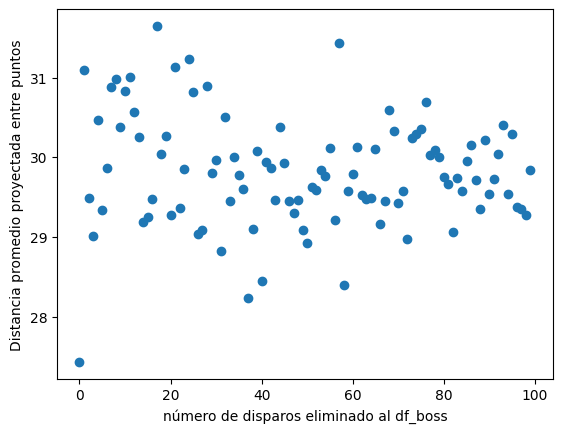

In [10]:
plt.scatter(list(range(0,len(mean))),mean)
plt.xlabel("número de disparos eliminado al df_boss")
plt.ylabel("Distancia promedio proyectada entre puntos")

Gráfico de las trazas en 3D

C:\Users\danie\AppData\Local\Temp\ipykernel_16276\3509942302.py:52: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
C:\Users\danie\AppData\Local\Temp\ipykernel_16276\3509942302.py:53: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
C:\Users\danie\AppData\Local\Temp\ipykernel_16276\3509942302.py:54: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


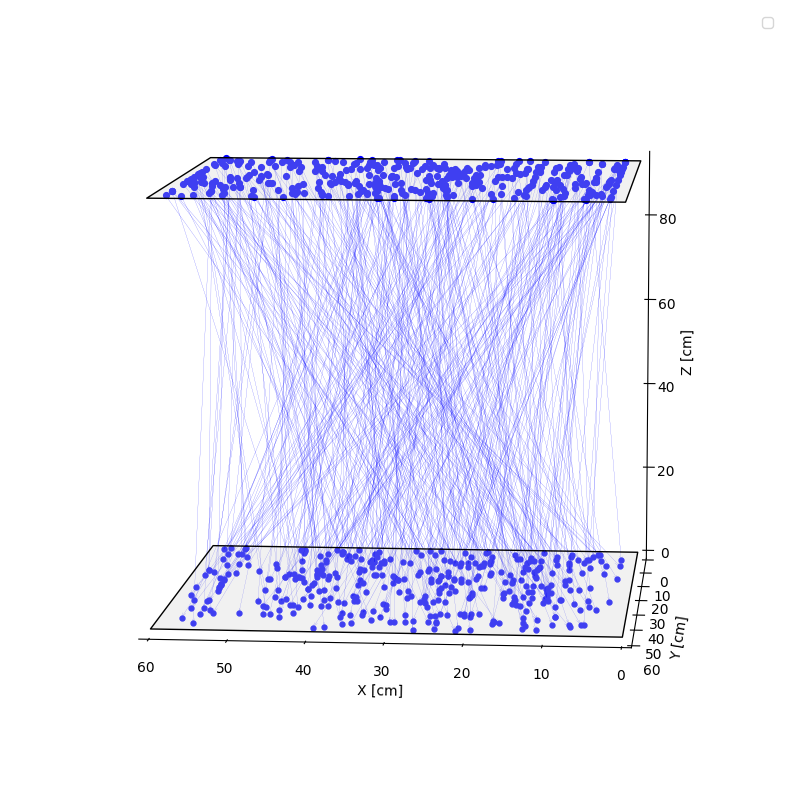

In [8]:
plate_size = (60, 60)
separation = 93

n = 10000
plate1_points = res_b[:,:2][:n]
plate2_points = res_s[:,:2][:n]


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.grid(False)

colors = [
    '#991f1f','#99251f','#992b1f','#99311f','#99371f','#993d1f','#99431f','#99491f','#99501f',
    '#99561f','#995c1f','#99621f','#99681f','#996e1f','#87991f','#81991f','#7a991f','#72991f',
    '#6a991f','#62991f','#5a991f','#4c991f','#3c991f','#2e991f','#1f991f','#1f9925','#1f992b',
    '#1f9931','#1f9937','#1f993d','#1f9943','#1f9949','#1f9950','#1f9956','#1f995c','#1f9962',
    '#1f9968','#1f996e','#1f8799','#1f8199','#1f7a99','#1f7299','#1f6a99','#1f6299','#1f5a99',
    '#1f4c99','#1f3c99','#1f2e99','#1f1f99','#251f99','#2b1f99','#311f99','#371f99','#3d1f99',
    '#431f99','#491f99','#501f99','#561f99','#5c1f99','#621f99','#681f99','#6e1f99','#741f99',
    '#7a1f99','#811f99','#871f99','#8d1f99','#931f99','#991f99','#991f93','#991f8d','#991f87',
    '#991f81','#991f7a','#991f74','#991f6e','#991f68'
]

# Draw semi-transparent plates as filled polygons
w, h = plate_size
for z in [0, separation]:
    verts = [(0, 0, z), (w, 0, z), (w, h, z), (0, h, z)]
    poly = Poly3DCollection([verts], facecolors='lightgray', edgecolors='black', alpha=0.3)
    ax.add_collection3d(poly)

i = 0
# Plot points and arrowed traces
for (x1, y1), (x2, y2) in zip(plate1_points, plate2_points):
    # Top plate point
    ax.scatter([x1], [y1], [0], marker='.', s=50, color="blue")
    
    # Compute vector from top to bottom
    dx, dy, dz = x1 - x2, y1 - y2, separation
    
    # Draw arrowed line (quiver) from top to bottom
    ax.quiver(x2, y2, separation, dx, dy, -dz,
                arrow_length_ratio=0.01, linestyle='-', linewidth=0.1,
                color="blue")
    
    # Bottom plate arrowhead marker
    ax.scatter([x2], [y2], [separation], marker='.', s=70, color="blue")
    i += 1

ax.view_init(elev=8, azim=95)
ax.set_box_aspect((plate_size[0], plate_size[1], 55))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_zlabel('Z [cm]')
ax.set_xlim(0, w)
ax.set_ylim(0, h)
ax.set_zlim(0, separation)
ax.legend()
plt.tight_layout()
plt.show()